**Author:** Boris Kundu

**Problem Statement:** Comparing different RNN models on Time-Series data

**Dataset:** COVID-19 hospitalizations

In [45]:
#Import packages
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [46]:
#Read data
data = np.genfromtxt('hospitalizations.txt', delimiter=' ')
hosp = data[:,1]

In [47]:
#Standardize data
mean = np.mean(hosp, axis=0)
std = np.std(hosp, axis=0)
hosp = (hosp - mean)/std

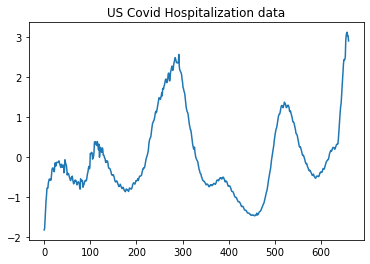

In [48]:
#Plot data
plt.plot(hosp)
plt.title('US Covid Hospitalization data')
plt.show()

In [49]:
#Parameters
last = len(hosp) #Total data points
seqlen = 20 # Input size or window size
batchsize = 50 # Data period and number of data points
trainbegin = np.random.randint(400) #Get random start day for training

In [50]:
#Preparing training data
Xtrain = np.array(hosp[trainbegin:trainbegin+seqlen])
ytrain = np.array(hosp[trainbegin+seqlen])
for i in range(1, batchsize):
    Xtrain = np.vstack([Xtrain, hosp[trainbegin+i:trainbegin+i+seqlen]])
    ytrain = np.append(ytrain, hosp[trainbegin+i+seqlen])

In [51]:
#Create tensors
X = torch.tensor(Xtrain, dtype=torch.float)
y = torch.tensor(ytrain, dtype=torch.float)

In [52]:
#Input parameters
inputsize = 1
hiddensize = 10
outputsize = 1
epochs = 1000
X2 = torch.reshape(X.T, (seqlen, batchsize, inputsize))

In [53]:
#Elman RNNCell optimized with Adam
class RNNCell(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(RNNCell, self).__init__()
        self.rnn = nn.RNNCell(inputsize, hiddensize)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(batchsize, hiddensize)
        for i in range(seqlen):
            hx = self.rnn(X2[i], hx)
        return self.layer2(hx)[:, 0]

In [54]:
#Initialize model
rnnc = RNNCell(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer_rnnc = optim.Adam(rnnc.parameters())

In [55]:
#Training model
def Train(model,epoch,optimizr,subject):
    for i in range(epoch):
        yhat = model(X2)
        L = F.mse_loss(yhat, y)
        if(i%100 == 0):
            print(f'{subject} Epoch:{i+1} with Loss:{L.item()}')
        optimizr.zero_grad()
        L.backward()
        optimizr.step()
    #Plot
    plotTrain(subject,yhat)

In [56]:
#Training Plot
def plotTrain(subject,yhat):
    plt.plot(y.detach().numpy())
    plt.plot(yhat.detach().numpy())
    plt.legend(['True','Predicted'])
    plt.title(f'{subject} - Training started at {str(trainbegin)}')
    plt.show()

RNNCell Epoch:1 with Loss:0.8344623446464539
RNNCell Epoch:101 with Loss:0.004985271021723747
RNNCell Epoch:201 with Loss:0.004348776303231716
RNNCell Epoch:301 with Loss:0.004224754404276609
RNNCell Epoch:401 with Loss:0.004079478792846203
RNNCell Epoch:501 with Loss:0.003917398862540722
RNNCell Epoch:601 with Loss:0.003738156519830227
RNNCell Epoch:701 with Loss:0.003543034428730607
RNNCell Epoch:801 with Loss:0.0033315380569547415
RNNCell Epoch:901 with Loss:0.0031036853324621916


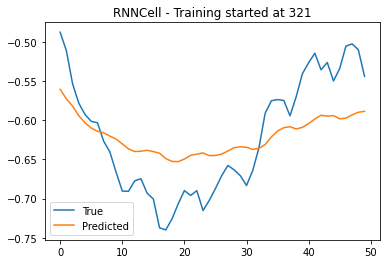

In [57]:
#Train RNNCell
Train(rnnc,epochs,optimizer_rnnc,'RNNCell')

In [58]:
#Deep 2-layer RNN model
class RNN(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(inputsize,hiddensize,2) #2-layer RNN
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn (2, batchsize , hiddensize)
        output, _ = self.rnn (X2,hx)
        return self.layer2(output[seqlen - 1])[:, 0]

In [59]:
#Define model
rnn = RNN(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer_rnn = optim.Adam(rnn.parameters())

RNN Epoch:1 with Loss:0.5697957873344421
RNN Epoch:101 with Loss:0.0055502038449049
RNN Epoch:201 with Loss:0.005451940465718508
RNN Epoch:301 with Loss:0.005391082726418972
RNN Epoch:401 with Loss:0.005319118034094572
RNN Epoch:501 with Loss:0.005233553238213062
RNN Epoch:601 with Loss:0.00512787327170372
RNN Epoch:701 with Loss:0.00499265780672431
RNN Epoch:801 with Loss:0.004805488511919975
RNN Epoch:901 with Loss:0.004524664953351021


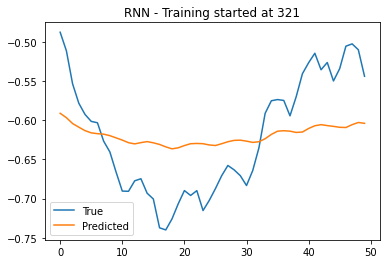

In [60]:
#Train deep 2-layer RNN
Train(rnn,epochs,optimizer_rnn,'RNN')

In [61]:
#nn.Linear model
class Linear(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(Linear, self).__init__()
        self.rnn = nn.Linear(inputsize + hiddensize , hiddensize)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(batchsize, hiddensize)
        for i in range(seqlen):
            hx = torch.tanh(self.rnn(torch.cat((X2[i],hx),1)))
        return self.layer2(hx)[:, 0]

In [62]:
#Define model
lin = Linear(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer_lin = optim.Adam(lin.parameters())

Linear Epoch:1 with Loss:0.23988322913646698
Linear Epoch:101 with Loss:0.0025761418510228395
Linear Epoch:201 with Loss:0.002354511059820652
Linear Epoch:301 with Loss:0.002073234412819147
Linear Epoch:401 with Loss:0.0017607626505196095
Linear Epoch:501 with Loss:0.0014710963005200028
Linear Epoch:601 with Loss:0.0012758837547153234
Linear Epoch:701 with Loss:0.001161526539362967
Linear Epoch:801 with Loss:0.001071886857971549
Linear Epoch:901 with Loss:0.000993377179838717


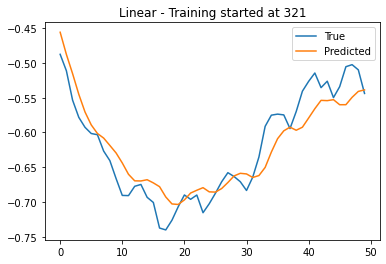

In [63]:
#Train Linear
Train(lin,epochs,optimizer_lin,'Linear')